<a href="https://colab.research.google.com/github/Monique14041980/dtat-brent-price/blob/main/Modulo04v04_ipea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install xgboost

#xgboost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import matplotlib.pyplot as plt

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime

# URL do site IPEADATA
url = 'http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view'

# Faz uma requisição GET ao site e captura a resposta
response = requests.get(url)

# Verifica se a requisição foi bem sucedida
if response.status_code == 200:
    # Cria um objeto BeautifulSoup para analisar o HTML
    soup = BeautifulSoup(response.text, 'html.parser')

    # Procura pela tabela no HTML analisado (o id ou classe pode variar)
    # Você precisaria inspecionar o HTML para obter o seletor correto
    table = soup.find('table', {'id': 'grd_DXMainTable'})

    # Usa o pandas para ler a tabela HTML diretamente para um DataFrame
    df = pd.read_html(str(table),skiprows=0)[0]

    df.columns = df.iloc[0]
    df = df.drop(0)

    # Mostra as primeiras linhas do DataFrame
    df.head()
else:
    print('Falha ao acessar a página: Status Code', response.status_code)


In [ ]:
df.head()

,Data,Preço - petróleo bruto - Brent (FOB)
1,03/05/2024,8360
2,02/05/2024,8481
3,01/05/2024,8355
4,30/04/2024,8823
5,29/04/2024,8844


#update com request

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime


# Função para atualizar o DataFrame com novos dados
def update_dataframe(df, new_data):

    # Converte a coluna 'Data' para datetime
    df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
    new_data['Data'] = pd.to_datetime(new_data['Data'], dayfirst=True)


    # Encontra a data mais recente no DataFrame existente
    last_date = df['Data'].max()

    # Filtra as novas linhas que são mais recentes do que a última data
    new_rows = new_data[new_data['Data'] > last_date]

    # Concatena os novos dados com o DataFrame existente se houver novas linhas
    if not new_rows.empty:
        updated_df = pd.concat([df, new_rows], ignore_index=True)
    else:
        updated_df = df

    return updated_df

# URL do site IPEADATA
url = 'http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view'

# Faz uma requisição GET ao site e captura a resposta
response = requests.get(url)

# Verifica se a requisição foi bem sucedida
if response.status_code == 200:
    # Cria um objeto BeautifulSoup para analisar o HTML
    soup = BeautifulSoup(response.text, 'html.parser')
    # Procura pela tabela no HTML analisado
    table = soup.find('table', {'id': 'grd_DXMainTable'})
    # Usa o pandas para ler a tabela HTML diretamente para um DataFrame
    new_df = pd.read_html(str(table), header=0)[0]

    # Verifica se o arquivo do DataFrame existe e carrega, ou cria um novo DataFrame se não existir
    path = '/content/ipea.csv'
    try:
        existing_df = pd.read_csv(path)
    except FileNotFoundError:
        existing_df = new_df  # Se o arquivo não existir, considere os dados atuais como o DataFrame existente

    # Atualiza o DataFrame existente com novos dados (carga incremental)
    updated_df = update_dataframe(existing_df, new_df)

    updated_df['Preço - petróleo bruto - Brent (FOB)'] = updated_df['Preço - petróleo bruto - Brent (FOB)']/100

    # Salva o DataFrame atualizado para o arquivo
    updated_df.to_csv(path, index=False)

    # Mostra as primeiras linhas do DataFrame atualizado
    updated_df.head()
else:
    print('Falha ao acessar a página: Status Code', response.status_code)

In [ ]:
updated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11164 entries, 0 to 11163
Data columns (total 2 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Data                                  11164 non-null  datetime64[ns]
 1   Preço - petróleo bruto - Brent (FOB)  11164 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 174.6 KB


#Xgboost

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator


# Carregar o DataFrame
df = pd.read_csv('/content/ipea.csv')
df['Data'] = pd.to_datetime(df['Data'])
df = df.sort_values(by='Data', ascending=True).reset_index(drop=True)
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
#df['Preço'] = df['Preço'].astype(float)
# Certifique-se de que os preços são float

# É uma boa prática criar recursos de atraso (lag features) para séries temporais
# Vamos criar alguns para nosso modelo
# Criar recursos de atraso (lag features)
lags = 7
for lag in range(1, lags + 1):
    df[f'Preço_lag_{lag}'] = df['Preço - petróleo bruto - Brent (FOB)'].shift(lag)

# Removemos quaisquer linhas com valores NaN que foram criados ao fazer o shift
df = df.dropna()

# Preparando os dados para treinamento
X = df[['Preço_lag_1']].values  # Inputs são os preços atrasados
y = df['Preço - petróleo bruto - Brent (FOB)'].values  # Output é o preço atual

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# modelo XGBoost com ajustes nos parâmetros
modelo = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,  # número de estimadores
    learning_rate=0.05,  # Ajuste a taxa de aprendizado
    max_depth=6,  # Ajuste a profundidade máxima da árvore
)
modelo.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Mean Squared Error: 2.8505457632950115
Mean Absolute Error: 1.1917500199439848


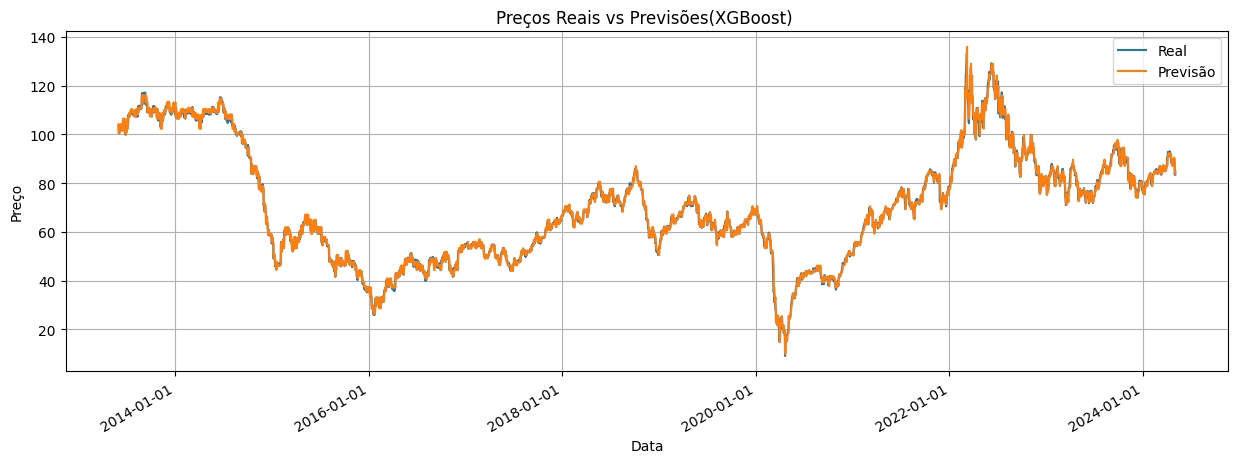

In [ ]:
# Fazer previsões
predictions = modelo.predict(X_test)

# Avaliar o modelo
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

# Opcional: Plotando resultados reais vs previstos. Tem que ter matplotlib instalado.
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(15, 5))
plt.plot(df['Data'].iloc[-len(y_test):], y_test, label='Real')
plt.plot(df['Data'].iloc[-len(predictions):], predictions, label='Previsão')
# Melhorar a formatação do eixo x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Formatar as datas como 'Ano-Mês-Dia'
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())             # Escolher automaticamente a localização das datas
# Melhorar a legibilidade girando as datas e ajustando o espaçamento
plt.gcf().autofmt_xdate()  # Gira as datas para evitar sobreposição
plt.legend()
plt.xlabel('Data')
plt.ylabel('Preço')
plt.grid(True)
plt.title('Preços Reais vs Previsões(XGBoost) ')
plt.show()

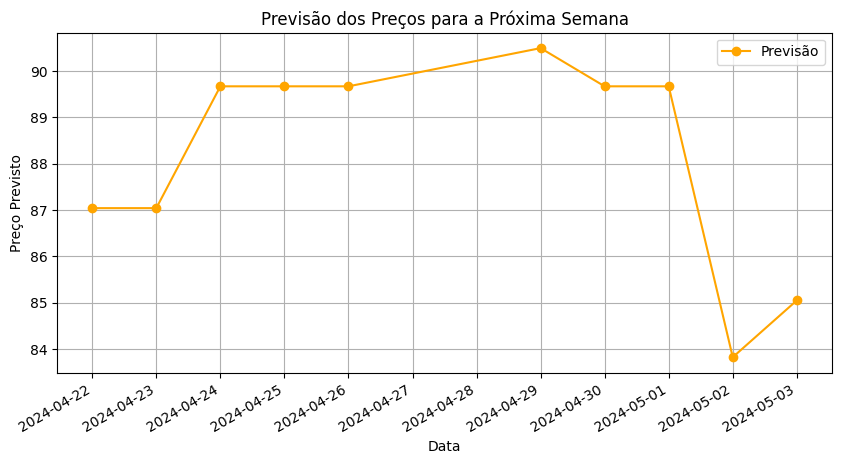

In [ ]:
predictions_next_week = predictions[-10:]  # Ajustar o número conforme necessário
df_next_week_dates = df['Data'].iloc[-len(y_test):][-10:]  # Ajustar o número conforme necessário

# Plotar os resultados
plt.figure(figsize=(10, 5))
# Certifique-se de reverter os dados para que as datas sejam plotadas em ordem cronológica
plt.plot(df_next_week_dates[::-1], predictions_next_week[::-1], label='Previsão', color='orange', marker='o')

# Formatar o eixo x para apresentar as datas
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gcf().autofmt_xdate()  # Auto formatar as datas para evitar sobreposição

plt.title('Previsão dos Preços para a Próxima Semana')
plt.xlabel('Data')
plt.ylabel('Preço Previsto')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
len(predictions)

3348

In [ ]:
X_train

array([[ 18.6 ],
       [ 18.58],
       [ 18.65],
       ...,
       [101.24],
       [102.14],
       [101.79]])

2024-05-04 00:00:00: 85.05
2024-05-05 00:00:00: 85.05
2024-05-06 00:00:00: 85.05
2024-05-07 00:00:00: 85.05
2024-05-08 00:00:00: 85.05
2024-05-09 00:00:00: 85.05
2024-05-10 00:00:00: 85.05


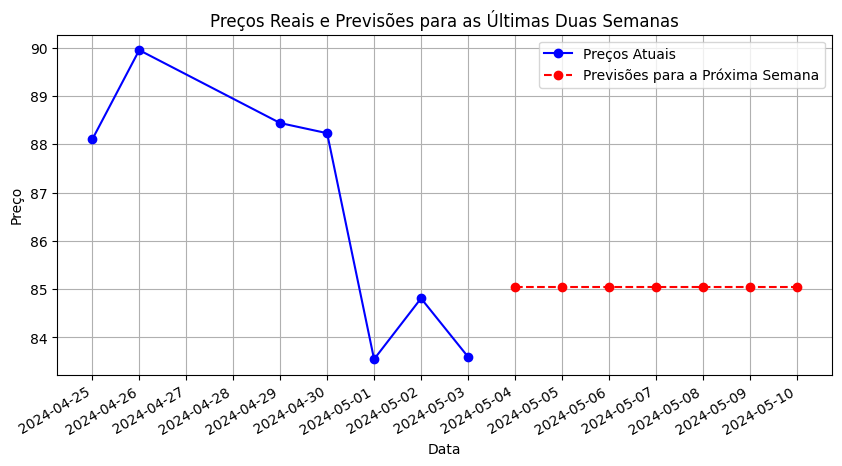

In [ ]:
# Carregar o DataFrame
df = pd.read_csv('/content/ipea.csv')
df['Data'] = pd.to_datetime(df['Data'])
df = df.sort_values(by='Data', ascending=True).reset_index(drop=True)
#df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
#df['Preço'] = df['Preço'].astype(float)  # Certifique-se de que os preços são float
# Fazer previsões para a próxima semana usando os últimos dados conhecidos

last_known_data = X[-1].reshape(1, -1)
next_week_predictions = []
for _ in range(7):  # para cada dia da próxima semana
    next_day_pred = modelo.predict(last_known_data)[0]
    next_week_predictions.append(next_day_pred)
    last_known_data = np.roll(last_known_data, -1)
    last_known_data[0, -1] = next_day_pred

# As datas correspondentes à próxima semana
next_week_dates = pd.date_range(df['Data'].iloc[-1], periods=8)[1:]

# Selecionar os dados da semana atual (últimos 7 dias do dataset)
current_week_dates = df['Data'].iloc[-7:]
current_week_prices = df['Preço - petróleo bruto - Brent (FOB)'].iloc[-7:]

for week, pred in zip(next_week_dates, next_week_predictions):
    print(f'{week}: {pred:.2f}')

# Plotar os preços reais da semana atual e as previsões para a próxima semana
plt.figure(figsize=(10, 5))
plt.plot(current_week_dates, current_week_prices, 'bo-', label='Preços Atuais')
plt.plot(next_week_dates, next_week_predictions, 'r--o', label='Previsões para a Próxima Semana')

# Formatar o eixo x para exibir datas
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gcf().autofmt_xdate()  # Ajustar formato das datas para evitar sobreposição

plt.xlabel('Data')
plt.ylabel('Preço')
plt.title('Preços Reais e Previsões para as Últimas Duas Semanas')
plt.legend()
plt.grid(True)
plt.show()


#XGBoost

In [ ]:


from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import xgboost as xgb


# Carregar o DataFrame
df = pd.read_csv('/content/ipea.csv')
df['Data'] = pd.to_datetime(df['Data'])
df = df.sort_values(by='Data', ascending=True).reset_index(drop=True)
#df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
#df['Preço'] = df['Preço'].astype(float)  # Certifique-se de que os preços são float

# É uma boa prática criar recursos de atraso (lag features) para séries temporais
# Vamos criar alguns para nosso modelo
# Criar recursos de atraso (lag features)
lags = 7
for lag in range(1, lags + 1):
    df[f'Preço_lag_{lag}'] = df['Preço - petróleo bruto - Brent (FOB)'].shift(lag)

# Removemos quaisquer linhas com valores NaN que foram criados ao fazer o shift
df = df.dropna()

# Preparando os dados para treinamento
X = df[['Preço_lag_1']].values  # Inputs são os preços atrasados
y = df['Preço - petróleo bruto - Brent (FOB)'].values  # Output é o preço atual

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)


#RandomForest

In [ ]:

from sklearn.ensemble import RandomForestRegressor
# Criar e treinar o modelo Random Forest
model_rf = RandomForestRegressor(n_estimators=300, random_state=42)
model_rf.fit(X_train, y_train)


RandomForestRegressor(n_estimators=300, random_state=42)

In [ ]:
# Fazer previsões
predictions = model_rf.predict(X_test)

# Avaliar o modelo
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

In [ ]:
print(f'MSE: {mse:.2f}')
print(f'MAE: {mae:.2f}')

MSE: 4.15
MAE: 1.50


2024-05-04 00:00:00: 85.74
2024-05-05 00:00:00: 86.73
2024-05-06 00:00:00: 85.88
2024-05-07 00:00:00: 83.89
2024-05-08 00:00:00: 83.80
2024-05-09 00:00:00: 83.04
2024-05-10 00:00:00: 83.39


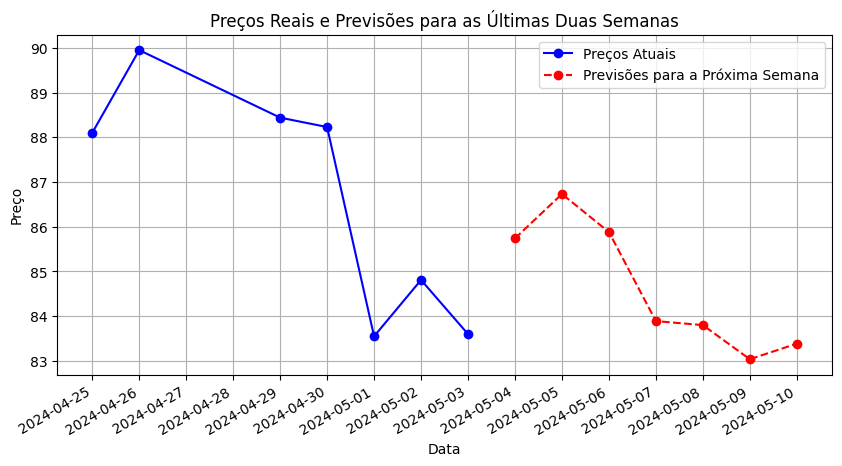

In [ ]:

# Fazer previsões para a próxima semana usando os últimos dados conhecidos
last_known_data = X[-1].reshape(1, -1)
next_week_predictions = []
for _ in range(7):  # para cada dia da próxima semana
    next_day_pred = model_rf.predict(last_known_data)[0]
    next_week_predictions.append(next_day_pred)
    last_known_data = np.roll(last_known_data, -1)
    last_known_data[0, -1] = next_day_pred

# As datas correspondentes à próxima semana
next_week_dates = pd.date_range(df['Data'].iloc[-1], periods=8)[1:]

# Selecionar os dados da semana atual (últimos 7 dias do dataset)
current_week_dates = df['Data'].iloc[-7:]
current_week_prices = df['Preço - petróleo bruto - Brent (FOB)'].iloc[-7:]

for week, pred in zip(next_week_dates, next_week_predictions):
    print(f'{week}: {pred:.2f}')

# Plotar os preços reais da semana atual e as previsões para a próxima semana
plt.figure(figsize=(10, 5))
plt.plot(current_week_dates, current_week_prices, 'bo-', label='Preços Atuais')
plt.plot(next_week_dates, next_week_predictions, 'r--o', label='Previsões para a Próxima Semana')

# Formatar o eixo x para exibir datas
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gcf().autofmt_xdate()  # Ajustar formato das datas para evitar sobreposição

plt.xlabel('Data')
plt.ylabel('Preço')
plt.title('Preços Reais e Previsões para as Últimas Duas Semanas')
plt.legend()
plt.grid(True)
plt.show()